# Sediment Tray Design

Code to develop the sediment tray ...

In [18]:
import netCDF4 as nc4
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta, date
import warnings
import math
from stone_lab_fns import *

## Constants

- Density of sand: $\rho_s = 2650 $ kg/m$^3  = 2.65$ g/cm$^3$    
- Density of fresh fluid: $\rho_f = 997 $ kg/m$^3 = 0.997$ g/cm$^3$   
- Density difference: $\Delta \rho = \rho_s - \rho_f = 1653$ kg/m$^3 = 1.653$ g/cm$^3$  
- Specific density: $s = \frac{\rho_s}{\rho_f} = 2.65$
- Specific gravity: $s_g = \frac{\rho_s - \rho_f}{\rho_f} = 1.658$
- Gravity: $g = 9.81$ m/s$^2 = 980$ cm/s$^2$  
- Kinematic viscosity: $\mu = 0.00139 $ kg/m/s $= 0.0139$ g/cm/s (10$^{\circ}$C saltwater) 
- Dynamic viscosity: $\nu = \frac{\mu}{\rho_f} = 1.39 \times 10^{-6}$ m$^2$/s
- von Karmen's constant, $\kappa \approx 0.41$

In [19]:
# constants
rhos = 2650 # kg/m3
rhof = 997 # kg/m3
drho = rhos - rhof # kg/m3
g = 9.81 # m/s2
sdense = rhos / rhof # typ 2.65, specific density
sgrav = (rhos - rhof) / rhof # typ 1.65, specific gravity
mu = 0.00139 # kg/m/s
nu = mu / rhof # m2/s
kappa = 0.41
D50 = 0.15/1000 # m, median sediment size, model = 0.15

## Givens:

Wave and water level properties:
- Frequencies: $f_1, f_2$  
- Amplitudes: $a_1, a_2$  

Sediment properties:
- Sediment size: $d_{50} = 0.15$ mm

Lab domain

In [20]:
# define bichromatic wave and water properties
f1 = 0.5 # frequency 
f2 = 0.43 # frequency 
a1 = 0.05 # amplitude  
a2 = 0.05 # amplitude
swl = 1.2 #1.5 # still water level at the wavemaker
theta0 = 0 # wave direction relative to shore-normal
gammab = 0.5 # breaking threshold (H/h)

# lab domain
lab_slope = 1/43.5#43.5 #1/32
lab_depth = 1.5 + 0.48 #1.2 + 0.48 #1.5+0.48
lab_beach = 1.36 
lab_length = 63

### Particle setting velocity: 
Assuming laminar settling, spherical particle, discrete particle, steady state, Stokes settling velocity is computed as:
$$
W_s = \frac{d_p^2\Delta \rho g}{18 \mu} = \frac{g(G-1) d_p^2}{18 \nu}
$$
where $d_p$ is the particle diameter ($d_{p,mm} = 2^{-\phi}$), $\Delta\rho$ is the difference between the density of the sediment ($\rho_s$) and fluid ($\rho_f$), $g$ is gravity, and $\mu$ is dynamic viscosity of the fluid.

In [21]:
def calculate_ws(D50, drho, g, mu):
    ws = ((D50 ** 2) * drho * g) / (18 * mu)
    return ws

# settling velocity
ws = calculate_ws(D50, drho, g, mu)
print(f"Ws = {ws:.4f} m/s")

Ws = 0.0146 m/s


## Wave field

### Bulk statistics and timeseries

$$\omega^2 = gk \tanh(kh)$$  
$$\eta = a_1 \cos(\omega_1 t - k_1 x + \phi_1) + a_2 \cos(\omega_2 t - k_2 x + \phi_2)$$
wave group period ($T_g$)
$$T_g = \frac{1}{f} = \frac{1}{f_1 - f_2}$$
where the peak wave period is:
$$T_p = \frac{1}{f_p} = \frac{2}{f_1 + f_2}$$
and $f_p$ is the average frequency.

In [22]:
# Bichromatic wave period and wavelength
T = 2 / (f1 + f2)  # Peak wave period

# Compute primary wave parameters
omega, k0 = calc_omega_k(1 / T, swl)  # Angular frequency and wavenumber of bichromatic waves
L = 2 * np.pi / k0  # Wavelength
c = L / T
[omega1, k1] = calc_omega_k(f1, swl)
[omega2, k2] = calc_omega_k(f2, swl)

# Maximum wave height and amplitude
H0 = 2 * (a1 + a2)
a0 = H0 / 2

### Long wave

Considering the superposition of two waves with different frequencies and the same amplitude:
$$\eta = a \cos (k_1 x - \omega_1 t) + a \cos (k_2 x - \omega_2 t)$$

The wave phase velocities are: $c_1 = \frac{\omega_1}{k_1}$ and $c_2 = \frac{\omega_1}{k_2}$

$\eta$ can be rewritten as:
$$\eta = 2 a \cos \left(\frac{k_1+k_2}{2} x - \frac{\omega_1+\omega_2}{2} t \right) \cos \left( \frac{k_2-k_1}{2} x - \frac{\omega_2 - \omega_1}{2} t\right)$$

where the short,fast wave has the speed: $c_{fast} = \frac{\omega_2 + \omega_1}{k_2 + k_1}$ and the long, slow wave group has the speed: $c_g = c_{slow} = \frac{\omega_2 - \omega_1}{k_2 - k_1}$

Energy: 
$$ E = \frac{1}{2} \rho g (a_1 + a_2)^2 $$
Radiation Stress:
$$S_{xx} = E \left( \frac{2k_gh}{\sinh 2k_gh} + \frac{1}{2} \right)$$ 
or
$$S_{xx} = E \left( \frac{2c_g}{c} - \frac{1}{2} \right)$$
Longuet-Higgens 1962 formulation
$$\eta_g = -\frac{1}{\rho} \frac{S_{xx}}{gh - c_g^2}$$
The group wave period is: 
$$ T_g = \frac{1}{f_1 - f_2}$$

In [23]:
# Compute long wave parameters
Tg = 1 / (f1 - f2)  # Group period
# omegag = 2 * np.pi / Tg
omegag = omega1 - omega2
# kg = k1 - k2
fg = f1 - f2  # Group frequency
# cg = (omega1 - omega2) / (k1 - k2)
# # kg2 = calc_omega_k(fg, swl)[1]
# # print(kg/2)
# # print(kg2)

# Eg = 0.5 * rhof * g * (a1 + a2) ** 2 # energy of group
# # Sxx = Eg * ((2 * kg * swl) / np.sinh(2 * kg * swl) + 0.5) # radiation stress of group
# Sxx = Eg * (( 2 * cg / c ) - 0.5)
# ag = - (1/rhof) * Sxx / (g * swl - cg**2) # amplitude of bound wave from L-H '62
# # print(Sxx)
# # print(Sxx2)

ag = calc_LH_boundwave(a1, a2, f1, f2, swl, 0)

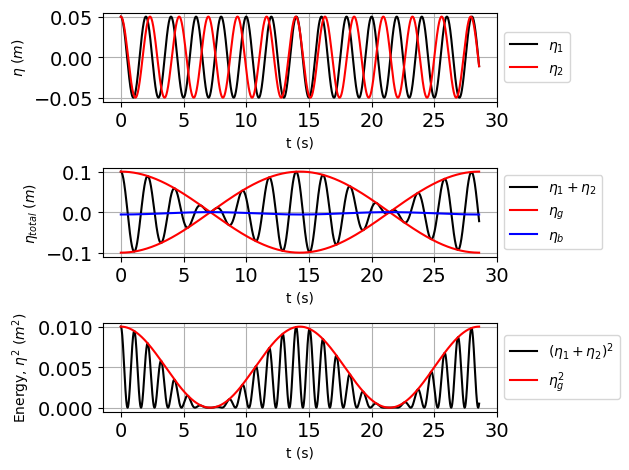

In [24]:
dt = Tg / 1000
Nt = int(2 * Tg / dt)
t = np.linspace(0, 2 * Tg, Nt)

eta1 = a1 * np.cos(omega1 * t)
eta2 = a2 * np.cos(omega2 * t)
etag = (a1 + a2) * np.cos(0.5 * omegag * t)

# Eg_t = 0.5 * rhof * g * ((a1 + a2) * np.cos(0.5 * omegag * t)) ** 2 # energy of group as a fn of time
# # Sxx_t = Eg_t * ((2 * kg * swl) / np.sinh(2 * kg * swl) + 0.5) # radiation stress of group as a fn of time
# Sxx_t = Eg_t * (( 2 * cg / c ) - 0.5) # radiation stress of group as a fn of time
# ag_t = - (1/rhof) * Sxx_t / (g * swl - cg**2) # amplitude of bound wave as a fn of time
ag_t = calc_LH_boundwave(a1, a2, f1, f2, swl, t)

ftsz = 14
plt.figure(1)
plt.clf()

plt.subplot(3, 1, 1)
plt.plot(t, eta1, 'k-', label=r'$\eta_1$')
plt.plot(t, eta2, 'r-', label=r'$\eta_2$')
plt.axis('tight')
plt.xlabel('t (s)')
plt.ylabel(r'$\eta~(m)$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.xticks(fontsize=ftsz)
plt.yticks(fontsize=ftsz)

plt.subplot(3, 1, 2)
plt.plot(t, (eta1 + eta2), 'k-', label=r'$\eta_1 + \eta_2$')
plt.plot(t, etag, 'r-', label=r'$\eta_g$')
plt.plot(t, -etag, 'r-')
plt.plot(t, ag_t, 'b', label=r'$\eta_{b}$')
plt.axis('tight')
plt.xlabel('t (s)')
plt.ylabel(r'$\eta_{total}~(m)$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.xticks(fontsize=ftsz)
plt.yticks(fontsize=ftsz)

plt.subplot(3, 1, 3)
plt.plot(t, (eta1 + eta2)**2, 'k-', label=r'$(\eta_1 + \eta_2)^2$')
plt.plot(t, etag**2, 'r-', label=r'$\eta_g^2$')
plt.axis('tight')
plt.xlabel('t (s)')
plt.ylabel(r'Energy, $\eta^2~(m^2)$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.xticks(fontsize=ftsz)
plt.yticks(fontsize=ftsz)

plt.tight_layout()
plt.show()

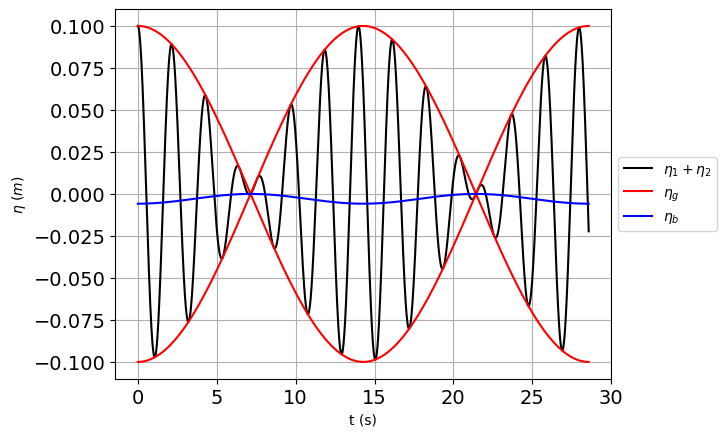

In [25]:
dt = Tg / 1000
Nt = int(2 * Tg / dt)
t = np.linspace(0, 2 * Tg, Nt)

eta1 = a1 * np.cos(omega1 * t)
eta2 = a2 * np.cos(omega2 * t)
etag = (a1 + a2) * np.cos(0.5 * omegag * t)
ag_t = calc_LH_boundwave(a1, a2, f1, f2, swl, t)

plt.plot(t, (eta1 + eta2), 'k-', label=r'$\eta_1 + \eta_2$')
plt.plot(t, etag, 'r-', label=r'$\eta_g$')
plt.plot(t, -etag, 'r-')
plt.plot(t, ag_t, 'b', label=r'$\eta_{b}$')
plt.axis('tight')
plt.xlabel('t (s)')
plt.ylabel(r'$\eta~(m)$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.xticks(fontsize=ftsz)
plt.yticks(fontsize=ftsz)
plt.show()

### Shoal waves

In [26]:
# define bathymetry
d, h, winloc = define_profile(lab_slope, lab_depth, lab_beach, lab_length, swl)

In [27]:
wave_max =  waveshoal_h_nonmono(T, H0, theta0, gammab, h)
wave_half =  waveshoal_h_nonmono(T, H0/2, theta0, gammab, h)

L = wave_max['L']
H = wave_max['H']
ib = wave_max['breaking_index'] + 1 # offset maybe due to the transistion between matlab and python?
hb = wave_max['breaking_depth'] # water depth at breaking
Hb = wave_max['breaking_height'] # wave height at breaking
theta = wave_max['theta']
ab = Hb / 2 # amplitude at breaking
Lb = L[ib] # wavelength at breaking
thetab = theta[ib] # angle at breaking
shoalcoef = Hb / H0
print(f'Ratio of offshore to onshore wave height at breaking: {shoalcoef:.3f}')

Ratio of offshore to onshore wave height at breaking: 1.081


Wave parameters at breaking

In [28]:
# shoal amplitudes at breaking
a1s = shoalcoef * a1
a2s = shoalcoef * a2
# wavenumber at breaking
[omega1b, k1b] = calc_omega_k(f1, hb)
[omega2b, k2b] = calc_omega_k(f2, hb)
[omegagb, kgb] = calc_omega_k(fg, hb)  # Long wave wavenumber using dispersion

/Users/cmbaker9/Documents/Research/STONE/IGwaves/codes/sedcolab-stone/lab-scaling/stone_lab_fns.py:227: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return omega, float(k)


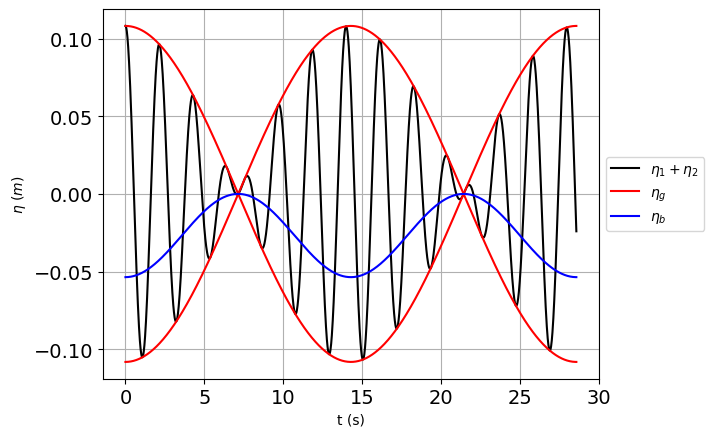

In [32]:
dt = Tg / 1000
Nt = int(2 * Tg / dt)
t = np.linspace(0, 2 * Tg, Nt)

eta1 = a1s * np.cos(omega1 * t)
eta2 = a2s * np.cos(omega2 * t)
etag = (a1s + a2s) * np.cos(0.5 * omegag * t)
ag_t = calc_LH_boundwave(a1s, a2s, f1, f2, hb, t)

plt.plot(t, (eta1 + eta2), 'k-', label=r'$\eta_1 + \eta_2$')
plt.plot(t, etag, 'r-', label=r'$\eta_g$')
plt.plot(t, -etag, 'r-')
plt.plot(t, ag_t, 'b', label=r'$\eta_{b}$')
plt.axis('tight')
plt.xlabel('t (s)')
plt.ylabel(r'$\eta~(m)$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.xticks(fontsize=ftsz)
plt.yticks(fontsize=ftsz)
plt.show()

# How long should the tray be? 

### Orbital velocities and Particle Displacements

Orbital velocities and excursion at bottom boundary
$$
\tilde{u}_{b} = a \omega \frac{\cosh [k (z+d)]]}{\sinh (kd)} cos \theta
$$

$$
\tilde{a}_{b} = \frac{\tilde{u}_{b}}{\omega}
$$

### Run a simple model to quantify particle horizontal displacement
Assume linear interference and assess the time it takes a particle to reach the bed from initial position $z_{bed}$

SS ab at breaking = 0.157 m
IG ab at breaking = -0.063 m


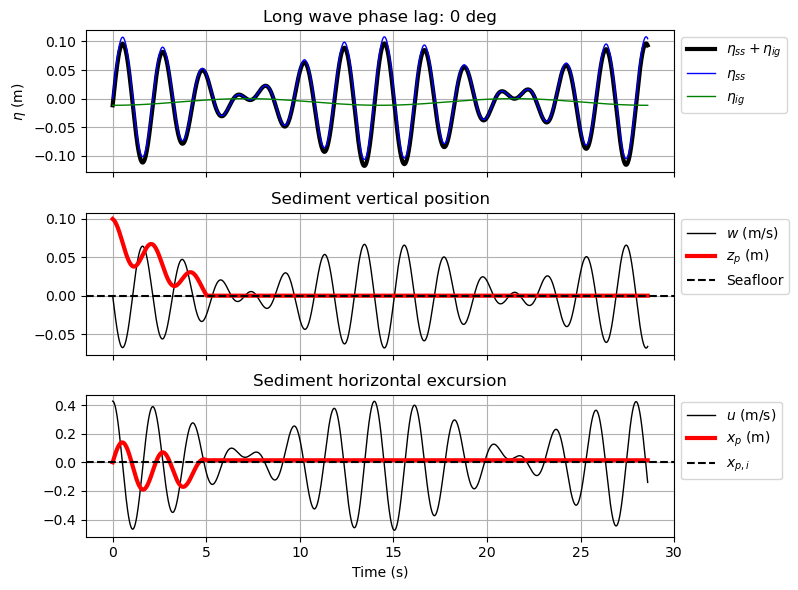

In [13]:
# inputs
dt = 0.01 # temporal resolution
zbed = 0.1 # height above bed
agb = ag #* shoalcoef # increasing ig energy, a bit arbitrary 

# Time array for visualization (two group periods)
t = np.arange(0, 2 * Tg + dt, dt)

# Water surface elevation
phi = 0
phig = 0#np.pi
eta_short = a1s * np.sin(omega1b * t + phi) + a2s * np.sin(omega2b * t + phi)
eta_long = agb + agb * np.cos(omegagb * t + phig)
eta = eta_short + eta_long

# Compute velocities for each wave component
z0 = zbed-hb
x = 0
zeta = orbital_velocity(ab, 2 * np.pi / T, 2 * np.pi / Lb, z0, hb, t, x, phi)[2]
u1, w1 = orbital_velocity(a1s, omega1b, k1b, z0, hb, t, x, phi)[:2]
u2, w2 = orbital_velocity(a2s, omega2b, k2b, z0, hb, t, x, phi)[:2]
ug, wg, zetag = orbital_velocity(agb, omegagb, kgb, z0, hb+(agb/2), t, x, phig)[:3]  # Long wave component
print(f"SS ab at breaking = {zeta:.3f} m")
print(f"IG ab at breaking = {zetag:.3f} m")

# Sum up the velocities
u_total = u1 + u2 + ug  # Total horizontal velocity
w_total = w1 + w2 + wg  # Total vertical velocity

# Initialize sediment position arrays
z_sediment = np.zeros_like(t)
x_sediment = np.zeros_like(t)
z_sediment[0] = zbed
x_sediment[0] = 0

# Time stepping loop to track sediment position
for i in range(1, len(t)):
    dz = w_total[i] * dt - ws * dt  # Vertical displacement
    dx = u_total[i] * dt  # Horizontal displacement
    
    # New positions
    z_sediment[i] = z_sediment[i-1] + dz
    x_sediment[i] = x_sediment[i-1] + dx
    
    # Stop forloop if particle reaches the bed
    if z_sediment[i] < 0:
        z_sediment[i] = 0
        # Set all subsequent horizontal positions to the last valid position
        x_sediment[i:] = x_sediment[i-1]
        break

# Plot results
fig, ax = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

ax[0].plot(t, eta, label=r"$\eta_{ss} + \eta_{ig}$", color='k', lw=3)
ax[0].plot(t, eta_short, label=r"$\eta_{ss}$", color='b',linestyle='-', lw=1)
ax[0].plot(t, eta_long, label=r"$\eta_{ig}$", color='g', lw=1)
ax[0].set_ylabel(r"$\eta$ (m)")
ax[0].set_title(f"Long wave phase lag: {phi:.2g} deg")
ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
ax[0].grid()

ax[1].plot(t, w_total, label=r"$w$ (m/s)", color='k', lw=1)
ax[1].plot(t, z_sediment, label=r"$z_{p}$ (m)", color='r', lw=3)
ax[1].axhline(y=0, color='k', linestyle='--', label="Seafloor")
ax[1].set_ylabel("")
ax[1].set_title("Sediment vertical position")
ax[1].legend(loc='upper left', bbox_to_anchor=(1, 1))
ax[1].grid()

ax[2].plot(t, u_total, label=r"$u$ (m/s)", color='k', lw=1)
ax[2].plot(t, x_sediment, label=r"$x_{p}$ (m)", color='r', lw=3)
ax[2].axhline(y=0, color='k', linestyle='--', label=r"$x_{p,i}$")
ax[2].set_xlabel("Time (s)")
ax[2].set_ylabel("")
ax[2].set_title("Sediment horizontal excursion")
ax[2].legend(loc='upper left', bbox_to_anchor=(1, 1))
ax[2].grid()

plt.tight_layout()

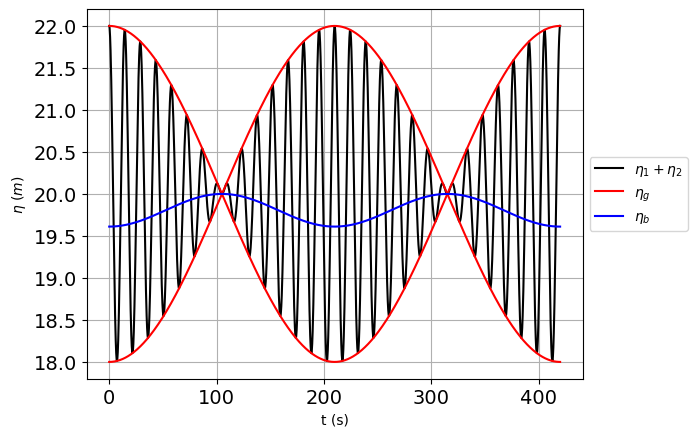

In [15]:
# # checking against Bertin
# a1 = a2 = 1
# f1 = 1/14
# f2 = 1/15
# Tg = 1 / (f1 - f2)  # Group period
# dt = Tg / 1000
# Nt = int(2 * Tg / dt)
# t = np.linspace(0, 2 * Tg, Nt)
# omega1 = 2 * np.pi * f1
# omega2 = 2 * np.pi * f2
# omegag = omega1 - omega2

# eta1 = a1 * np.cos(2 * np.pi * f1 * t)
# eta2 = a2 * np.cos(2 * np.pi * f2 * t)
# etag = (a1 + a2) * np.cos(0.5 * omegag * t)
# ag_t = calc_LH_boundwave(a1, a2, f1, f2, 20, t)

# plt.plot(t, (eta1 + eta2)+20, 'k-', label=r'$\eta_1 + \eta_2$')
# plt.plot(t, etag+20, 'r-', label=r'$\eta_g$')
# plt.plot(t, -etag+20, 'r-')
# plt.plot(t, ag_t+20, 'b', label=r'$\eta_{b}$')
# plt.axis('tight')
# plt.xlabel('t (s)')
# plt.ylabel(r'$\eta~(m)$')
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.grid(True)
# plt.xticks(fontsize=ftsz)
# plt.yticks(fontsize=ftsz)
# plt.show()

# How deep should the tray be?

### Ustar
**Ustar from the frictional velocity or shear velocity**  
The frictional coefficient is
$$
f_w = \exp\left[ 5.213 \left( \frac{2.5 d_{50}}{\tilde{a}_{b}} \right) ^{0.194} -5.977 \right]
$$

**Shear velocity**
bed shear stress is
$$
\tau_{bw} = \frac{2}{3\pi}\rho_ff_w \tilde{u}_{b}^2~~[\mathrm{N/m}^2]
$$
such that
$$
u_* = \sqrt{\frac{\tau_{bw}}{\rho_f}} = \sqrt{\frac{2f_w}{3\pi}} \tilde{u}_{b}
$$

**Frictional velocity**
$$
u_* = \sqrt{f_w} u_{rms} = \sqrt{\frac{f_w}{2}}\tilde{u}_{b}
$$

Note, the shear velocity is less than the frictional velocity method by a factor of 0.65. 

Erodability
$$
E =
\begin{cases} 
E_0 \left(\frac{\tau_b}{\tau_c} - 1\right), & \tau_b > \tau_c \\ 
0, & \text{Otherwise}
\end{cases}
$$